In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from scipy.stats import randint

from nltk.corpus import stopwords
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler



from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, r2_score, precision_score, f1_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

from scipy.stats import uniform, loguniform

import pickle


In [85]:
## The following run in Terminal to facilitate BayesSearchCV
# pip install --force-reinstall "scikit-learn==0.23.2"

In [86]:
data_raw = pd.read_csv('../data/allposts_struc.csv')
data_vecd = pd.read_csv('../data/merged_with_bigrams.csv')

In [87]:
#remove extra index column that made it into data_vecd
data_vecd.drop(columns='index', inplace=True)
data_raw.drop(columns='index', inplace=True)

In [88]:
data_raw.isnull().sum().sort_values(ascending=False).head()

lem_selftext    0
timestamp       0
subreddit       0
created_utc     0
is_self         0
dtype: int64

In [89]:
#baseline accuracy
data_vecd.subreddit.value_counts(normalize=True)

relationship_advice    0.50775
pettyrevenge           0.49225
Name: subreddit, dtype: float64

In [90]:
data_vecd['subreddit'] = data_vecd['subreddit'].apply(lambda x: 0 if x=='pettyrevenge' else 1)
data_raw['subreddit'] = data_raw['subreddit'].apply(lambda x: 0 if x=='pettyrevenge' else 1)

In [91]:
data_raw.subreddit.value_counts(normalize=True)

1    0.50775
0    0.49225
Name: subreddit, dtype: float64

# Modeling

In [92]:
#custom stopwords: 'english', + unique lems + 'im' just because
my_words = ['wa', 'ha', 'doe', 'a', 'im']
custom_stop = text.ENGLISH_STOP_WORDS.union(my_words)

In [93]:
#hand to calc scores manually because forgot to numify target before fitting first model...
def see_scores(model, X_test, y_test):
    preds = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    print(confusion_matrix(y_test, preds))
    
    print(f'\nAccuracy: {accuracy_score(y_test, preds).round(6)}')
    print(f'\nSensitivity: {(tp/(tp+fn)).round(6)}')
    print(f'\nPrecision: {tp/(tp+fp).round(6)}')
    print(f'\nSpecificity: {(tn/(tn+fp)).round(6)}')
    print(f'\nF1: {tp/(tp + 0.5*(fp + fn)).round(6)}')
    
    plot_confusion_matrix(model, X_test, y_test)
    

# Model 0: DecisionTree with 0 hyperparams
This was just to get a picture of how the tree was making decisions before pursuing more finetuned dtree and random forest models; and then I'd use that to guide BayesSearchCV params.  It scored suspiciously high. Printing the tree text revealed that the source of success in Models 1 and 2 is likely due to key words _relationship_ and _revenge_.  As such, I will include the title words of both subreddits in the stopwords for all subsequent models.

---

First fit already vectorized data (concatenated 1-gram and bigrams) with no params - will be overfit, but use to guide ranges in BayesSearchCV.  Takeaways:
* add title words to stopwords ('relationship', 'advice', 'petty', 'revenge')
* max branch depth was 71, then 48, 38, 25.  Lower branch depth to reduce overfitting.
    * to achieve purity (leaf=1)
    
---
Edit: Abandoning Decision Tree.  
By running RandomSearch over subsets of my data (10%), test scores across all metrics topped out around 80% with best_parameters.  I intended to move stepwise from Decision Tree to bootstrapped options, but since these scores are significantly lower than the Multinomial Bayes standard (presented below), I will move on instead of investing full-data-fit-time here.  Immediately below is the initial fit (on all data) with 0 hyperparam adjustment.  RandomSearch experiments on subsetted data were performed in separate notebook. 

In [94]:
X0=data_vecd.drop(columns=['author','num_comments','timestamp','num_sentences','avg_words_per_sent', 'wordcount','comma_count','qmark_count', 'exclamatios','is_mobile','subreddit'])
y0=data_vecd['subreddit']
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, random_state=42, test_size=.33)

In [95]:
dt0 = DecisionTreeClassifier(random_state=42)
dt0.fit(X0_train, y0_train)

DecisionTreeClassifier(random_state=42)

In [96]:
dt0.score(X0_train, y0_train), dt0.score(X0_test, y0_test)

(1.0, 0.8772727272727273)

In [97]:
## 'Relationship' (#1), 'advice', 'petty', and 'revenge' all in top 10 nodes.  
## Should've seen that coming.
## adjust stopwords
#print(export_text(dt0, list(X0_train.columns)))

[[1708  273]
 [ 213 1766]]

Accuracy: 0.877273

Sensitivity: 0.89237

Precision: 0.8661108386463953

Specificity: 0.862191

F1: 0.879044300647088


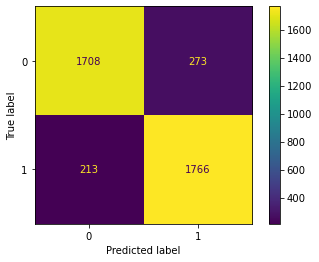

In [98]:
see_scores(dt0, X0_test, y0_test)

# Model 1: MNB with updated stopwords informed by Model 0
And a couple other tweaks to hone in on the ideal values from in first pipeline best_params.

In [99]:
#update
my_words = ['wa', 'ha', 'doe', 'a', 'im', 'relationship', 'advice','petty','revenge']
new_stop = text.ENGLISH_STOP_WORDS.union(my_words)

In [100]:
X = data_raw['lem_selftext']
y=data_raw['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.33)

In [101]:
pipe_b = Pipeline([
    ('cvec', CountVectorizer(stop_words=new_stop) ),
    ('mnb', MultinomialNB() ),
])

pipe_b_params = {
    'cvec__max_features': randint(6000,10000), #updated and expanded since more limiting stopwords
    'cvec__min_df': uniform(.001, .05),
    'cvec__max_df': uniform(.95, 1.), #updated to range, not discrete
    'cvec__ngram_range': [(1,3), (2,4)], #updated
    'mnb__alpha': uniform(.001,1)   # updated                   
}

In [102]:
b_vec_mnb = RandomizedSearchCV(estimator = pipe_b, 
                                param_distributions=pipe_b_params, 
                                scoring = 'f1_weighted',
                                random_state=42,
                                n_iter=1000,
                                cv=5,
                                n_jobs=-1, verbose=1)

In [103]:
# %%time
# b_vec_mnb.fit(X_train, y_train)

In [52]:
pkl_b_vec_mnb = '../models/vec_mnb2.pkl'

In [122]:
# with open (pkl_b_vec_mnb, 'wb') as file:
#     pickle.dump(b_vec_mnb, file)

In [104]:
with open(pkl_b_vec_mnb, 'rb') as file:
    mnb2_pickle = pickle.load(file)

In [54]:
mnb2_pickle.best_params_

{'cvec__max_df': 1.0018357991197289,
 'cvec__max_features': 6112,
 'cvec__min_df': 0.0019897829173627195,
 'cvec__ngram_range': (1, 3),
 'mnb__alpha': 0.3077765995221412}

In [55]:
mnb2_pickle.score(X_train, y_train), mnb2_pickle.score(X_test, y_test)

(0.963179184532175, 0.9575753030725069)

In [56]:
mnb2_pickle.best_params_  #cvec_max_df > 1 bc misunderstanding of loguniform(loc, scale) input

{'cvec__max_df': 1.0018357991197289,
 'cvec__max_features': 6112,
 'cvec__min_df': 0.0019897829173627195,
 'cvec__ngram_range': (1, 3),
 'mnb__alpha': 0.3077765995221412}

[[1890   91]
 [  77 1902]]

Accuracy: 0.957576

Sensitivity: 0.961091

Precision: 0.9543401906673357

Specificity: 0.954064

F1: 0.9577039274924471


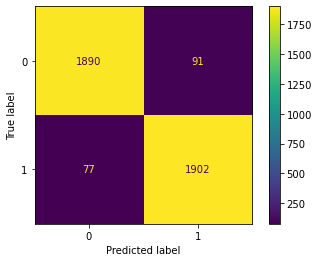

In [57]:
#see_scores(b_vec_mnb, X_test, y_test)
see_scores(mnb2_pickle, X_test, y_test)

In [58]:
coefs_df = pd.DataFrame(zip(mnb2_pickle.best_estimator_.named_steps['cvec'].get_feature_names(), 
                 mnb2_pickle.best_estimator_.named_steps['mnb'].coef_[0])).rename(columns={
    0:'word', 1:'coef'
}).sort_values('coef',ascending=False)

In [61]:
coefs_df.sort_values('coef',ascending=False).head(10).append(coefs_df.sort_values('coef',ascending=False).tail(10))

,word,coef
2667,just,-4.191152
3013,like,-4.224197
5347,time,-4.456228
5761,want,-4.513946
2823,know,-4.540410
1879,friend,-4.599262
1705,feel,-4.684960
4132,really,-4.752871
5244,thing,-4.812882
6044,year,-4.829528


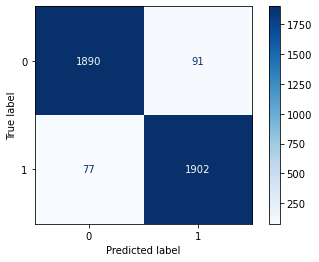

In [71]:
#better colors for presentation
plot_confusion_matrix(mnb2_pickle, X_test, y_test, cmap='Blues')

# Model 2: SVC + TF-IDF
Hyperparameters searched in this full-data fit are centered around results from subset testing.  I also tested TfidfVectorizer vs. CountVec in subset experimentation.  Tfidf won.

In [105]:
svctf_pipe = Pipeline([
    ('tf', TfidfVectorizer(stop_words=new_stop, ngram_range=(1,3)) ),
    ('svc', SVC(kernel='sigmoid', random_state=42) ) #sigmoid from subset best params
])

svctf_params = {
    'tf__max_features': randint(4000,7000),
    'tf__min_df': uniform(.001, .03), # = range .001-.051
    'tf__max_df': uniform(loc=.90, scale=.07), #uniform is a boobytrap
    #loc = starting val, scale = upwards range.  this translates to .93-.98
    
    'svc__degree': randint(2,5),
    'svc__C': loguniform(1e-1, 1e+2) #this works intuitively: start, stop vals
}

In [106]:
svctf_rs = RandomizedSearchCV(estimator = svctf_pipe,
                         param_distributions= svctf_params,
                         scoring = 'f1_weighted',
                         n_iter = 1000,
                         cv = 5,
                         n_jobs=-1,
                         random_state=42, verbose = 1)

In [20]:
%%time
svctf_rs.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/helenmeigs/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 35.4min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 56.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 87.3min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 124.3min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 163.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 201.9min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 245.2min
[Parallel(n_jobs=-1)]: Don

CPU times: user 1min 34s, sys: 2min 59s, total: 4min 34s
Wall time: 4h 6min 12s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tf',
                                              TfidfVectorizer(ngram_range=(1,
                                                                           3),
                                                              stop_words=frozenset({'a',
                                                                                    'about',
                                                                                    'above',
                                                                                    'across',
                                                                                    'advice',
                                                                                    'after',
                                                                                    'afterwards',
                                                                                    'again',
                   

In [23]:
pkl_svctf = '../models/svctf.pkl'

In [24]:
# with open (pkl_svctf, 'wb') as file:
#     pickle.dump(svctf_rs, file)

In [25]:
with open(pkl_svctf, 'rb') as file:
    svctf_rs = pickle.load(file)

[[1906   75]
 [  82 1897]]

Accuracy: 0.960354

Sensitivity: 0.958565

Precision: 0.9619675456389453

Specificity: 0.96214

F1: 0.9602632245001266


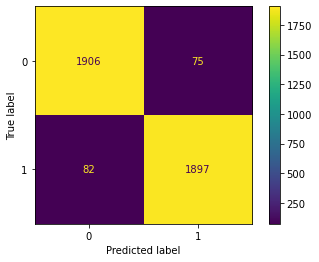

In [26]:
see_scores(svctf_rs, X_test, y_test)

In [49]:
svctf_rs.best_params_

{'svc__C': 0.6309945235509472,
 'svc__degree': 2,
 'tf__max_df': 0.9324866611617453,
 'tf__max_features': 4739,
 'tf__min_df': 0.0022497045514804728}

In [50]:
svctf_rs.score(X_train, y_train), svctf_rs.score(X_test, y_test)

(0.9756228096597498, 0.9603533760751343)

In [74]:
svctf_rs.best_estimator_

Pipeline(steps=[('tf',
                 TfidfVectorizer(max_df=0.9324866611617453, max_features=4739,
                                 min_df=0.0022497045514804728,
                                 ngram_range=(1, 3),
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'advice',
                                                       'after', 'afterwards',
                                                       'again', 'against',
                                                       'all', 'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
         

# Model 3: Logreg with RandomSearch
Best params on subset determined to be the following:  allowing a couple RandomSearch params here but mostly fixed.  

* 'cvec__max_df': 0.9836611966780151,
* 'cvec__max_features': 6019,
* 'cvec__min_df': 0.0099833053147566,
* 'logreg__C': 0.0001638175852226399,
* 'logreg__penalty': 'l2',
* 'logreg__solver': 'saga'

In [44]:
logreg_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=new_stop, max_df=.98, min_df=.01, max_features=7000) ),
    ('ss', StandardScaler(with_mean=False) ),
    ('logreg', LogisticRegression(random_state=42) )
])

logreg_params = {
                 'logreg__penalty': ['l1','l2'],
                'logreg__solver':['saga','liblinear'],
                 'logreg__C': loguniform(1e-5,1)
                }

In [45]:
logreg = RandomizedSearchCV(
    estimator = logreg_pipe,
    param_distributions = logreg_params,
    scoring='f1_weighted',
    n_iter=1000,
    cv=5,
    n_jobs=-1, random_state=42, verbose=1)

In [46]:
logreg.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/helenmeigs/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 25.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 32.7min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 41.0min
[Parallel(n_jobs=-1)]: Done 50

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('cvec',
                                              CountVectorizer(max_df=0.98,
                                                              max_features=7000,
                                                              min_df=0.01,
                                                              stop_words=frozenset({'a',
                                                                                    'about',
                                                                                    'above',
                                                                                    'across',
                                                                                    'advice',
                                                                                    'after',
                                                                                    'afterwards',
                                    

In [62]:
pkl_logreg = '../models/logreg.pkl'

In [63]:
# with open (pkl_logreg, 'wb') as file:
#      pickle.dump(logreg, file)

In [64]:
with open(pkl_logreg, 'rb') as file:
    logreg = pickle.load(file)

[[1889   92]
 [  84 1895]]

Accuracy: 0.955556

Sensitivity: 0.957554

Precision: 0.9536990437845999

Specificity: 0.953559

F1: 0.9556227937468482


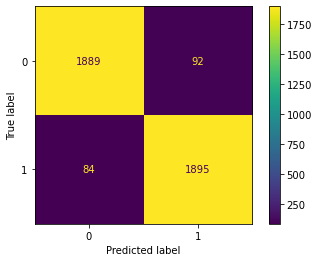

In [65]:
see_scores(logreg, X_test, y_test)

In [66]:
logreg.best_params_

{'logreg__C': 0.09460867797081408,
 'logreg__penalty': 'l1',
 'logreg__solver': 'saga'}

In [70]:
coefs_df = pd.DataFrame(zip(logreg.best_estimator_.named_steps['cvec'].get_feature_names(), 
                 logreg.best_estimator_.named_steps['logreg'].coef_[0])).rename(columns={
    0:'word', 1:'coef'
}).sort_values('coef',ascending=False)
coefs_df.sort_values('coef', ascending=False).head(20)

,word,coef
1573,want,0.429472
529,feel,0.408331
878,love,0.298075
685,help,0.283749
530,feeling,0.264569
1442,talk,0.238350
846,like,0.226246
803,know,0.222447
1557,ve,0.212607
1173,really,0.196193
